In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np

### **1.Getting dataset**

In [2]:
from torchvision import datasets
train_data = datasets.CIFAR10(
    root = "data",
    train = True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.CIFAR10(
    root = "data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 170498071/170498071 [00:06<00:00, 26530372.10it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [3]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"
device

'cuda'

In [4]:
!cd /content/drive/MyDrive/CIFAR10-Pytorch

In [5]:
len(train_data)

50000

In [6]:
len(test_data)

10000

In [7]:
img, label = train_data[0]

In [8]:
img.shape

torch.Size([3, 32, 32])

In [9]:
class_name  = train_data.classes
class_name

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [10]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

Image shape: torch.Size([3, 32, 32])


(-0.5, 31.5, 31.5, -0.5)

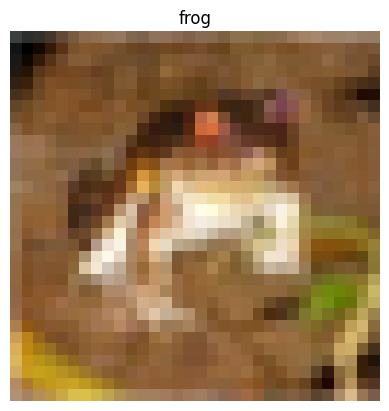

In [11]:
img , label = train_data[0]
print(f"Image shape: {img.shape}")
plt.imshow(img.permute(1,2,0))
plt.title(class_name[label])
plt.axis(False)

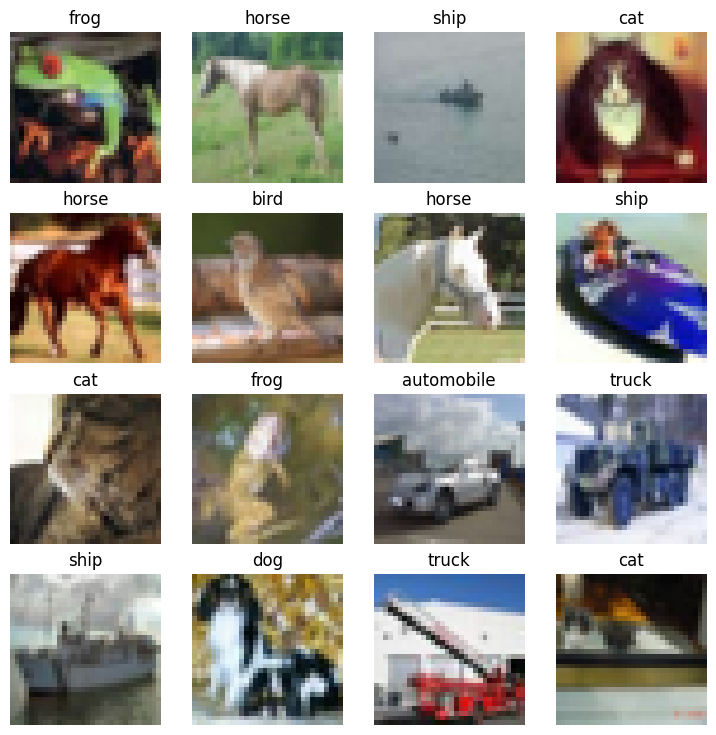

In [12]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.permute(1,2,0))
  plt.title(class_name[label])
  plt.axis(False)

### **2.Prepare DataLoader**

In [13]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [14]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=32,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=32,
    shuffle=False
)

In [15]:
X_train_batch, y_train_batch = next(iter(train_dataloader))
X_train_batch.shape, y_train_batch.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

torch.Size([3, 32, 32])


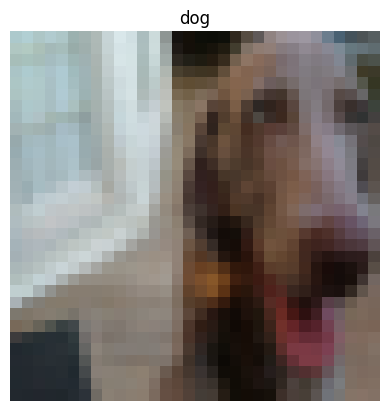

In [16]:
random_idx = torch.randint(0, len(X_train_batch), size=[1]).item()
img, label = X_train_batch[random_idx], y_train_batch[random_idx]
plt.imshow(img.permute(1, 2, 0))
plt.title(class_name[label])
plt.axis(False)
print(img.shape)

### **3.Building CNN**

In [17]:
img, label = train_data[0]
img.shape, label

(torch.Size([3, 32, 32]), 6)

In [81]:
class CIFAR10Model(nn.Module):
  def __init__(self):
    super().__init__()
    nn.Dropout(p=0.2)
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2) # 16x16
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2) # 8x8
    )
    nn.Dropout(p=0.2)
    self.fully_connected = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=8*8*128, out_features=512),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=10)
    )
  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.fully_connected(x)
    return x

In [82]:
model = CIFAR10Model().to(device)
model

CIFAR10Model(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fully_connected): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)

### **4.Training and Testing loop**


In [83]:
def acc_score(y_preds, y_true):
  # _, idx_pred = torch.max(y_preds, dim=1)
  pred = y_preds.argmax(dim=1)
  correct = torch.sum(pred==y_true).item()
  acc = torch.tensor(correct/len(y_preds))
  return acc

In [84]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [85]:
def train_step(model, data_loader, loss_fn, optimizer):
  train_loss, train_acc = 0, 0
  model.train()
  for X, y in data_loader:
    X, y = X.to(device), y.to(device)
    y_pred = model(X)

    loss = loss_fn(y_pred,y)
    train_loss += loss
    train_acc += acc_score(y_preds=y_pred, y_true=y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss} | Train accuracy: {train_acc}")

In [86]:
def test_step(model, data_loader, loss_fn, optimizer):
  test_loss, test_acc = 0, 0
  model.eval()
  for X, y in data_loader:
    X, y = X.to(device), y.to(device)
    y_pred = model(X)

    test_loss += loss_fn(y_pred, y)
    test_acc += acc_score(y_preds=y_pred, y_true=y)

  test_loss /= len(data_loader)
  test_acc /= len(data_loader)
  print(f"Test loss: {test_loss} | Test accuracy: {test_acc}\n")

In [87]:
torch.manual_seed(42)

epochs = 5
for epoch in range(epochs):
  print(f"Epoch: {epoch+1}")
  train_step(model=model, data_loader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer)
  test_step(model=model, data_loader=test_dataloader, loss_fn=loss_fn, optimizer=optimizer)

Epoch: 1
Train loss: 1.2888234853744507 | Train accuracy: 0.5365483164787292
Test loss: 0.9802108407020569 | Test accuracy: 0.65625

Epoch: 2
Train loss: 0.8309342861175537 | Train accuracy: 0.7082333564758301
Test loss: 0.811715304851532 | Test accuracy: 0.719648540019989

Epoch: 3
Train loss: 0.6141499280929565 | Train accuracy: 0.7854686379432678
Test loss: 0.7656983733177185 | Test accuracy: 0.748302698135376

Epoch: 4
Train loss: 0.43620777130126953 | Train accuracy: 0.8466890454292297
Test loss: 0.7859649062156677 | Test accuracy: 0.7470048069953918

Epoch: 5
Train loss: 0.2779964804649353 | Train accuracy: 0.90245121717453
Test loss: 0.9352142810821533 | Test accuracy: 0.7447084784507751



In [89]:
img, label = test_data[345]
img.shape

torch.Size([3, 32, 32])

In [90]:
img = img.to(device)
model.eval()
y_pred = model(torch.unsqueeze(img, dim=0))

out = y_pred.argmax(dim=1)
print(class_name[out.item()])
print(class_name[label])

dog
dog


In [91]:
for i in range(10):
  idx_rand = torch.randint(0, len(test_data), size=[1]).item()
  img, label = test_data[idx_rand]
  model.eval()
  y_pred = model(torch.unsqueeze(img, dim=0).to(device))
  out = y_pred.argmax(dim=1)
  print(f"Predicted: {class_name[out.item()]} | Actual: {class_name[label]}")

Predicted: automobile | Actual: automobile
Predicted: deer | Actual: deer
Predicted: horse | Actual: horse
Predicted: frog | Actual: frog
Predicted: cat | Actual: cat
Predicted: truck | Actual: truck
Predicted: automobile | Actual: automobile
Predicted: deer | Actual: horse
Predicted: bird | Actual: bird
Predicted: cat | Actual: airplane
